<a href="https://colab.research.google.com/github/oluwadunni1/beats-per-minute-prediction/blob/master/Model_bpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Install Required Packages

# Install standard ML libraries from the default PyPI index
!pip install xgboost lightgbm catboost -q

# Install PyTorch with CUDA 11.8 support from the PyTorch index
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q

print(" GPU-enabled packages installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00
✓ GPU-enabled packages installed


In [5]:
# Import Libraries
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)

# GPU-enabled libraries
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print(" All libraries imported")

✓ All libraries imported


In [1]:
# Cell 4: Mount Google Drive & Setup Paths
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Define the permanent path to your file on Google Drive
# NOTE: Replace 'your_file_name.csv' with your actual file name
file_path = '/content/drive/MyDrive/MusicBPMPrediction/train.csv'

# Load the dataframe directly from Drive
df = pd.read_csv(file_path)

print(f"Data loaded successfully with {len(df)} rows.")

Data loaded successfully with 524164 rows.


In [7]:
# Load Preprocessing Module
import sys
from pathlib import Path

# 1. Define where the script is saved
script_location = '/content/drive/MyDrive/MusicBPMPrediction'

# 2. Add that location to Python's "Search Path"
if script_location not in sys.path:
    sys.path.append(script_location)

# 3. import it just like a standard library
import preprocessing
import importlib
importlib.reload(preprocessing) # This ensures you always get the latest version if you edit the file

print(" 'preprocessing.py' successfully imported from Google Drive")

# 4. define factory
pipeline_factory = preprocessing.pipeline_factory


 'preprocessing.py' successfully imported from Google Drive


In [8]:
# Separate features and target
X = df.drop(columns=["BeatsPerMinute","id"])
y = df["BeatsPerMinute"]

print(f"\nFeatures: {X.shape[1]}")
print(f"Target: {y.name}")


Features: 9
Target: BeatsPerMinute


In [ ]:
# Create a small sample for testing just for validation
X_sample = X.sample(1000, random_state= 42).copy()

print("Pipeline Validation Test\n" + "="*70)

# Test each pipeline type
for model_type, factory_func in preprocessing.pipeline_factory.items():
    print(f"\nTesting: {model_type.upper()}")

    # Create pipeline
    preprocessor = factory_func()

    if preprocessor == 'passthrough':
        print("  ✓ No preprocessing (passthrough mode)")
        print(f"  ✓ Input shape: {X_sample.shape} → Output shape: {X_sample.shape}")
    else:
        # Fit and transform sample
        try:
            X_transformed = preprocessor.fit_transform(X_sample)
            print(f"  ✓ Pipeline executed successfully")
            print(f"  ✓ Input shape: {X_sample.shape} → Output shape: {X_transformed.shape}")
            print(f"  ✓ Output range: [{X_transformed.min():.3f}, {X_transformed.max():.3f}]")
            print(f"  ✓ Output mean: {X_transformed.mean():.3f}, std: {X_transformed.std():.3f}")
        except Exception as e:
            print(f"  ✗ Error: {e}")

print("\n" + "="*70)
print("All pipeline validations complete!")

Pipeline Validation Test

Testing: LINEAR
  ✓ Pipeline executed successfully
  ✓ Input shape: (1000, 9) → Output shape: (1000, 9)
  ✓ Output range: [-3.124, 2.759]
  ✓ Output mean: 0.000, std: 1.000

Testing: RIDGE
  ✓ Pipeline executed successfully
  ✓ Input shape: (1000, 9) → Output shape: (1000, 9)
  ✓ Output range: [-3.124, 2.759]
  ✓ Output mean: 0.000, std: 1.000

Testing: LASSO
  ✓ Pipeline executed successfully
  ✓ Input shape: (1000, 9) → Output shape: (1000, 9)
  ✓ Output range: [-3.124, 2.759]
  ✓ Output mean: 0.000, std: 1.000

Testing: ELASTICNET
  ✓ Pipeline executed successfully
  ✓ Input shape: (1000, 9) → Output shape: (1000, 9)
  ✓ Output range: [-3.124, 2.759]
  ✓ Output mean: 0.000, std: 1.000

Testing: GAM
  ✓ Pipeline executed successfully
  ✓ Input shape: (1000, 9) → Output shape: (1000, 9)
  ✓ Output range: [-3.124, 2.759]
  ✓ Output mean: 0.000, std: 1.000

Testing: SVR
  ✓ Pipeline executed successfully
  ✓ Input shape: (1000, 9) → Output shape: (1000, 9)
  ✓ 

In [ ]:
# Train/Test Split
print("\n" + "="*70)
print("TRAIN/TEST SPLIT")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f" Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X):.1%})")
print(f" Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X):.1%})")



TRAIN/TEST SPLIT
✓ Training set: 419,331 samples (80.0%)
✓ Test set: 104,833 samples (20.0%)


In [ ]:
# GPU-Optimized Model Registry
print("\n" + "="*70)
print("GPU-OPTIMIZED MODEL REGISTRY")
print("="*70)

# Detect GPU for tree models
gpu_available = torch.cuda.is_available()
print(f"GPU Available: {gpu_available}")

model_registry = {
    # === CPU Models (Fast Baselines) ===
    'Linear Regression': {
        'model': LinearRegression(),
        'preprocessor': 'linear',
        'cv_folds': 5,
        'device': 'CPU',
        'priority': 1
    },
    'Ridge': {
        'model': Ridge(alpha=1.0, random_state=42),
        'preprocessor': 'ridge',
        'cv_folds': 5,
        'device': 'CPU',
        'priority': 1
    },
    'Lasso': {
        'model': Lasso(alpha=1.0, random_state=42, max_iter=5000),
        'preprocessor': 'lasso',
        'cv_folds': 5,
        'device': 'CPU',
        'priority': 1
    },

    # === GPU-Accelerated Tree Models ===
    # FIXED: Removed 'early_stopping_rounds' to prevent Cross-Validation errors
    'XGBoost (GPU)': {
        'model': xgb.XGBRegressor(
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=6,
            tree_method='hist',
            device='cuda' if gpu_available else 'cpu',
            random_state=42,
            verbosity=0
        ),
        'preprocessor': 'xgboost',
        'cv_folds': 3,
        'device': 'GPU' if gpu_available else 'CPU',
        'priority': 2
    },
    'LightGBM (GPU)': {
        'model': lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=7,
            device='gpu' if gpu_available else 'cpu',
            random_state=42,
            verbose=-1
        ),
        'preprocessor': 'lightgbm',
        'cv_folds': 3,
        'device': 'GPU' if gpu_available else 'CPU',
        'priority': 2
    },
    'CatBoost (GPU)': {
        'model': cb.CatBoostRegressor(
            iterations=1000,
            learning_rate=0.05,
            depth=7,
            task_type='GPU' if gpu_available else 'CPU',
            random_state=42,
            verbose=0
        ),
        'preprocessor': 'catboost',
        'cv_folds': 3,
        'device': 'GPU' if gpu_available else 'CPU',
        'priority': 2
    },

    # === Neural Networks (Sklearn) ===
    'MLP (Neural Net)': {
        'model': MLPRegressor(
            hidden_layer_sizes=(128, 64, 32),
            activation='relu',
            solver='adam',
            max_iter=500,
            early_stopping=True, # MLP handles this internally, so it's safe here
            random_state=42
        ),
        'preprocessor': 'neural_network',
        'cv_folds': 3,
        'device': 'CPU',
        'priority': 3
    },

    # === Polynomial Models (Heavier) ===
    'Polynomial (Interaction)': {
        'model': Ridge(alpha=1.0, random_state=42),
        'preprocessor': 'polynomial_interact',
        'cv_folds': 3,
        'device': 'CPU',
        'priority': 3
    }
}

# Sort by priority for efficient training
model_registry = dict(sorted(model_registry.items(), key=lambda x: x[1]['priority']))

print(f"\n {len(model_registry)} models registered:")
for i, (name, config) in enumerate(model_registry.items(), 1):
    print(f"  {i:2d}. {name:25s} → {config['device']:15s} (Priority {config['priority']})")



GPU-OPTIMIZED MODEL REGISTRY
GPU Available: True

✓ 8 models registered:
   1. Linear Regression         → CPU             (Priority 1)
   2. Ridge                     → CPU             (Priority 1)
   3. Lasso                     → CPU             (Priority 1)
   4. XGBoost (GPU)             → GPU             (Priority 2)
   5. LightGBM (GPU)            → GPU             (Priority 2)
   6. CatBoost (GPU)            → GPU             (Priority 2)
   7. MLP (Neural Net)          → CPU             (Priority 3)
   8. Polynomial (Interaction)  → CPU             (Priority 3)


In [ ]:
# Training Functions
def create_model_pipeline(model, preprocessor_name):
    """Create pipeline with preprocessing and model"""
    preprocessor = pipeline_factory[preprocessor_name]()
    return Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

def evaluate_model(model_name, model_config, X_train, X_test, y_train, y_test, verbose=True):
    """Train and evaluate a single model with cross-validation"""
    if verbose:
        print(f"\n{'='*70}")
        print(f"Training: {model_name} ({model_config['device']})")
        print(f"{'='*70}")

    # Create pipeline
    pipeline = create_model_pipeline(
        model_config['model'],
        model_config['preprocessor']
    )

    if verbose:
        print(f"✓ Pipeline: '{model_config['preprocessor']}' preprocessing")

    # Cross-validation
    cv_start = time.time()
    cv_scores = cross_val_score(
        pipeline, X_train, y_train,
        cv=model_config['cv_folds'],
        scoring='neg_mean_squared_error',
        n_jobs=-1 if 'GPU' not in model_config['device'] else 1
    )
    cv_time = time.time() - cv_start
    cv_rmse_scores = np.sqrt(-cv_scores)

    if verbose:
        print(f" {model_config['cv_folds']}-Fold CV: {cv_rmse_scores.mean():.4f} ± {cv_rmse_scores.std():.4f} ({cv_time:.2f}s)")

    # Train on full training set
    train_start = time.time()

    # Special handling for XGBoost early stopping inside Pipeline (Tricky, so we use fit params if needed)
    # For simplicity in pipelines, we fit normally here.
    pipeline.fit(X_train, y_train)

    train_time = time.time() - train_start

    if verbose:
        print(f" Training time: {train_time:.2f}s")

    # Predictions
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Calculate metrics
    results = {
        'model_name': model_name,
        'preprocessor': model_config['preprocessor'],
        'device': model_config['device'],

        # Cross-validation
        'cv_rmse_mean': cv_rmse_scores.mean(),
        'cv_rmse_std': cv_rmse_scores.std(),
        'cv_time': cv_time,

        # Training set
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'train_mae': mean_absolute_error(y_train, y_pred_train),
        'train_r2': r2_score(y_train, y_pred_train),
        'train_time': train_time,

        # Test set
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'test_mae': mean_absolute_error(y_test, y_pred_test),
        'test_r2': r2_score(y_test, y_pred_test),
        'test_mape': mean_absolute_percentage_error(y_test, y_pred_test) * 100,

        # Predictions & Object
        'y_pred_test': y_pred_test,
        'pipeline': pipeline
    }

    if verbose:
        print(f" Test: RMSE={results['test_rmse']:.4f}, R²={results['test_r2']:.4f}")

    return results


In [ ]:
# Train All Models
print("\n" + "="*70)
print("TRAINING ALL MODELS (GPU-ACCELERATED)")
print("="*70)

all_results = []
total_start = time.time()

for model_name, model_config in model_registry.items():
    try:
        result = evaluate_model(
            model_name,
            model_config,
            X_train, X_test, y_train, y_test,
            verbose=True
        )
        all_results.append(result)

        # Clear GPU memory
        if 'GPU' in model_config['device'] and torch.cuda.is_available():
            torch.cuda.empty_cache()

    except Exception as e:
        print(f"\n Error training {model_name}: {e}")
        import traceback
        traceback.print_exc()
        continue

total_time = time.time() - total_start

print(f"\n{'='*70}")
print(f"TRAINING COMPLETE")
print(f"{'='*70}")
print(f" Successfully trained: {len(all_results)}/{len(model_registry)} models")
print(f" Total time: {total_time/60:.2f} minutes")


TRAINING ALL MODELS (GPU-ACCELERATED)

Training: Linear Regression (CPU)
✓ Pipeline: 'linear' preprocessing
✓ 5-Fold CV: 26.4719 ± 0.0515 (4.36s)
✓ Training time: 0.65s
📊 Test: RMSE=26.4440, R²=0.0001

Training: Ridge (CPU)
✓ Pipeline: 'ridge' preprocessing
✓ 5-Fold CV: 26.4719 ± 0.0515 (2.69s)
✓ Training time: 0.77s
📊 Test: RMSE=26.4440, R²=0.0001

Training: Lasso (CPU)
✓ Pipeline: 'lasso' preprocessing
✓ 5-Fold CV: 26.4737 ± 0.0513 (3.08s)
✓ Training time: 0.59s
📊 Test: RMSE=26.4454, R²=-0.0000

Training: XGBoost (GPU) (GPU)
✓ Pipeline: 'xgboost' preprocessing
✓ 3-Fold CV: 26.5908 ± 0.0289 (10.71s)
✓ Training time: 4.00s
📊 Test: RMSE=26.5320, R²=-0.0066

Training: LightGBM (GPU) (GPU)
✓ Pipeline: 'lightgbm' preprocessing
✓ 3-Fold CV: 26.5264 ± 0.0312 (58.85s)
✓ Training time: 12.90s
📊 Test: RMSE=26.4765, R²=-0.0024

Training: CatBoost (GPU) (GPU)
✓ Pipeline: 'catboost' preprocessing
✓ 3-Fold CV: 26.5012 ± 0.0311 (23.23s)
✓ Training time: 8.89s
📊 Test: RMSE=26.4647, R²=-0.0015

Train

In [ ]:
# Results Comparison
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

results_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Device': r['device'],
        'Preprocessor': r['preprocessor'],
        'CV RMSE': r['cv_rmse_mean'],
        'CV Std': r['cv_rmse_std'],
        'Test RMSE': r['test_rmse'],
        'Test MAE': r['test_mae'],
        'Test R²': r['test_r2'],
        'Test MAPE': r['test_mape'],
        'Train Time (s)': r['train_time'],
        'CV Time (s)': r['cv_time']
    }
    for r in all_results
]).sort_values('Test RMSE')

print("\n All Models Ranked by Test RMSE:")
display(results_df)

best_model_result = all_results[results_df.index[0]]
print(f"\n Best Model: {best_model_result['model_name']}")
print(f"   Device: {best_model_result['device']}")
print(f"   Test RMSE: {best_model_result['test_rmse']:.4f}")
print(f"   Test R²: {best_model_result['test_r2']:.4f}")


MODEL COMPARISON

📊 All Models Ranked by Test RMSE:


,Model,Device,Preprocessor,CV RMSE,CV Std,Test RMSE,Test MAE,Test R²,Test MAPE,Train Time (s),CV Time (s)
1,Ridge,CPU,ridge,26.471897,0.051543,26.444029,21.184128,0.000084,19.790347,0.773540,2.685821
0,Linear Regression,CPU,linear,26.471897,0.051543,26.444029,21.184128,0.000084,19.790347,0.654780,4.358213
7,Polynomial (Interaction),CPU,polynomial_interact,26.473110,0.032540,26.444983,21.185256,0.000012,19.790877,1.629206,4.548858
2,Lasso,CPU,lasso,26.473721,0.051314,26.445357,21.186405,-0.000017,19.792782,0.587862,3.080406
6,MLP (Neural Net),CPU,neural_network,26.476491,0.035788,26.448384,21.187752,-0.000246,19.831058,326.994356,361.285241
5,CatBoost (GPU),GPU,catboost,26.501236,0.031065,26.464694,21.204456,-0.001480,19.803965,8.885567,23.232175
4,LightGBM (GPU),GPU,lightgbm,26.526450,0.031213,26.476488,21.211209,-0.002373,19.809185,12.900134,58.849286
3,XGBoost (GPU),GPU,xgboost,26.590806,0.028931,26.531960,21.256841,-0.006577,19.848194,3.995785,10.712381



🏆 Best Model: Ridge
   Device: CPU
   Test RMSE: 26.4440
   Test R²: 0.0001


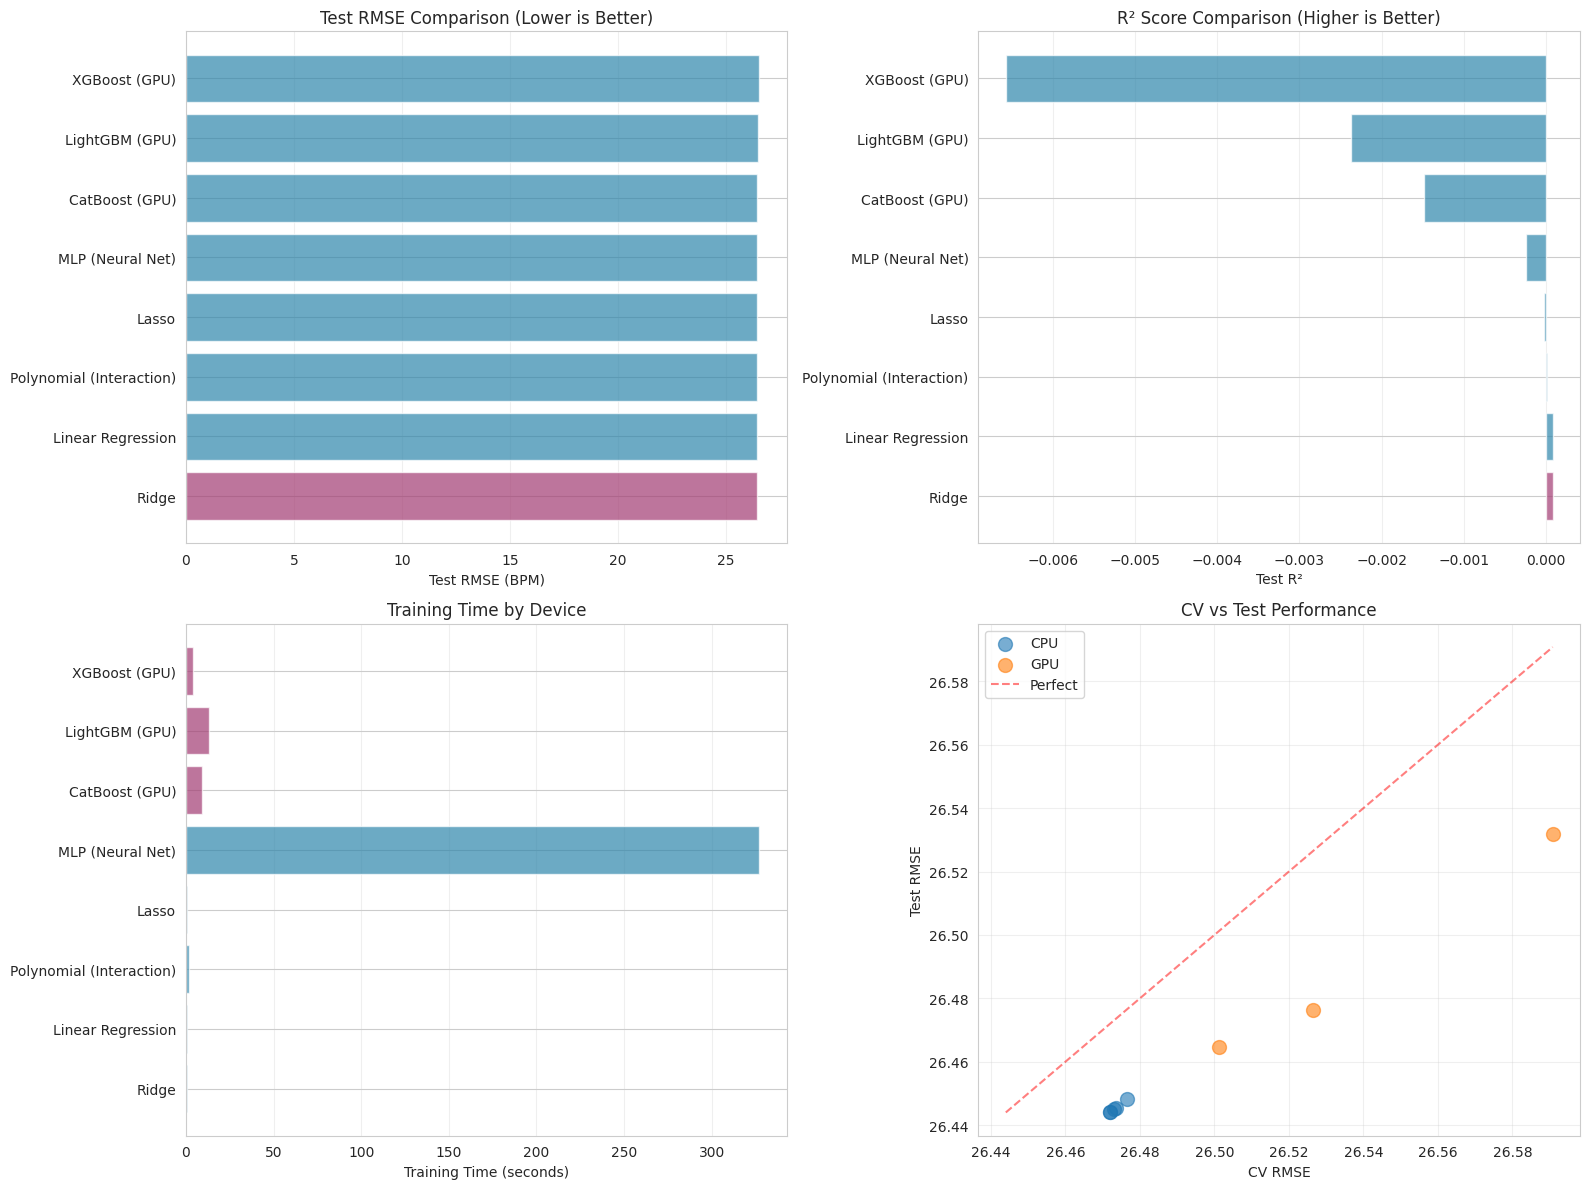

In [ ]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Test RMSE
ax1 = axes[0, 0]
colors = ['#A23B72' if i == 0 else '#2E86AB' for i in range(len(results_df))]
ax1.barh(results_df['Model'], results_df['Test RMSE'], color=colors, alpha=0.7)
ax1.set_xlabel('Test RMSE (BPM)')
ax1.set_title('Test RMSE Comparison (Lower is Better)')
ax1.grid(alpha=0.3, axis='x')

# 2. R² Score
ax2 = axes[0, 1]
ax2.barh(results_df['Model'], results_df['Test R²'], color=colors, alpha=0.7)
ax2.set_xlabel('Test R²')
ax2.set_title('R² Score Comparison (Higher is Better)')
ax2.grid(alpha=0.3, axis='x')

# 3. Training Time by Device
ax3 = axes[1, 0]
device_colors = results_df['Device'].map({
    'CPU': '#2E86AB',
    'CPU (Multi-core)': '#3A9EBF',
    'GPU': '#A23B72'
})
ax3.barh(results_df['Model'], results_df['Train Time (s)'], color=device_colors, alpha=0.7)
ax3.set_xlabel('Training Time (seconds)')
ax3.set_title('Training Time by Device')
ax3.grid(alpha=0.3, axis='x')

# 4. CV vs Test RMSE
ax4 = axes[1, 1]
for device in results_df['Device'].unique():
    mask = results_df['Device'] == device
    ax4.scatter(results_df[mask]['CV RMSE'], results_df[mask]['Test RMSE'],
               label=device, s=100, alpha=0.6)
min_val = min(results_df['CV RMSE'].min(), results_df['Test RMSE'].min())
max_val = max(results_df['CV RMSE'].max(), results_df['Test RMSE'].max())
ax4.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='Perfect')
ax4.set_xlabel('CV RMSE')
ax4.set_ylabel('Test RMSE')
ax4.set_title('CV vs Test Performance')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()



BEST MODEL: Ridge

📊 Metrics:
  RMSE: 26.4440 BPM
  MAE:  21.1841 BPM
  R²:   0.0001
  MAPE: 19.79%


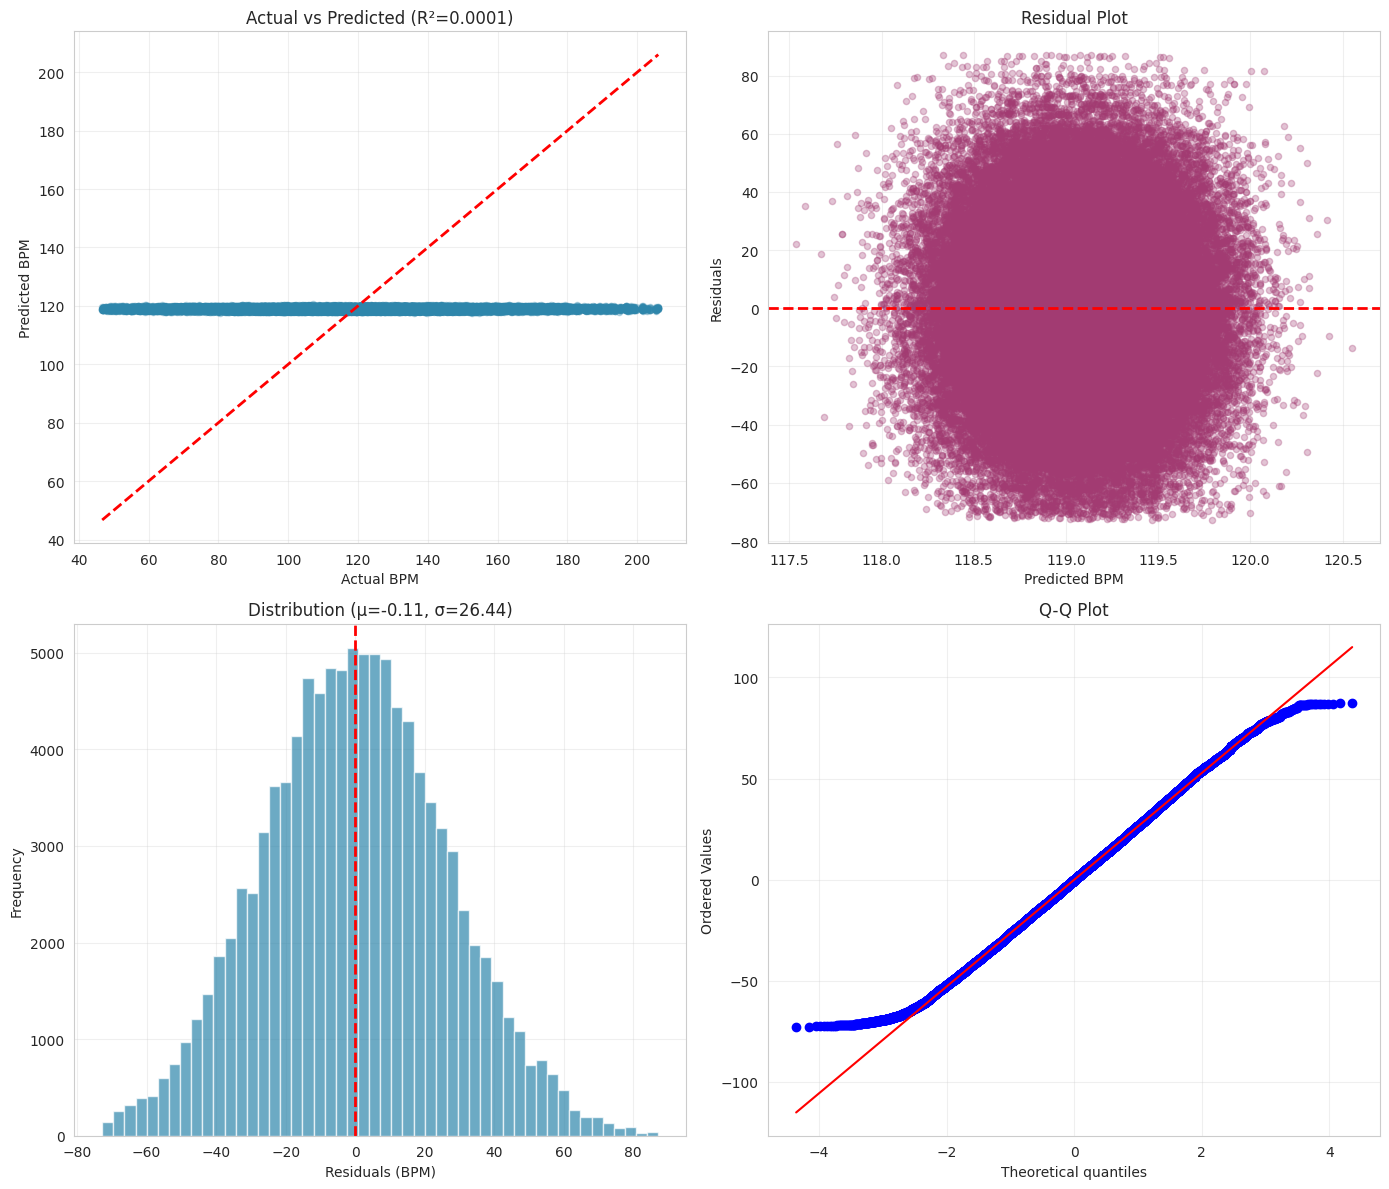

In [ ]:
# Best Model Detailed Analysis
print("\n" + "="*70)
print(f"BEST MODEL: {best_model_result['model_name']}")
print("="*70)

y_pred_best = best_model_result['y_pred_test']
residuals = y_test - y_pred_best

print(f"\n Metrics:")
print(f"  RMSE: {best_model_result['test_rmse']:.4f} BPM")
print(f"  MAE:  {best_model_result['test_mae']:.4f} BPM")
print(f"  R²:   {best_model_result['test_r2']:.4f}")
print(f"  MAPE: {best_model_result['test_mape']:.2f}%")

# Diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Actual vs Predicted
axes[0, 0].scatter(y_test, y_pred_best, alpha=0.3, s=20, color='#2E86AB')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                'r--', lw=2)
axes[0, 0].set_xlabel('Actual BPM')
axes[0, 0].set_ylabel('Predicted BPM')
axes[0, 0].set_title(f'Actual vs Predicted (R²={best_model_result["test_r2"]:.4f})')
axes[0, 0].grid(alpha=0.3)

# Residual Plot
axes[0, 1].scatter(y_pred_best, residuals, alpha=0.3, s=20, color='#A23B72')
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted BPM')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(alpha=0.3)

# Residual Distribution
axes[1, 0].hist(residuals, bins=50, color='#2E86AB', alpha=0.7, edgecolor='white')
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuals (BPM)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Distribution (μ={residuals.mean():.2f}, σ={residuals.std():.2f})')
axes[1, 0].grid(alpha=0.3)

# Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Results Analysis

Eight models were evaluated, ranging from linear baselines to GPU-accelerated ensembles. As anticipated from EDA, the dataset exhibits **extremely low predictive signal** for BPM. Ridge regression emerged as the best-performing model, but only by converging to a mean baseline predictor, achieving a Test RMSE of **26.44** and an $R^2 \approx 0.0001$.

Although the **residuals appear approximately normally distributed and centered around zero**, this reflects the natural variability of the target rather than learned structure, indicating that the model captured only the central tendency while the remaining error is pure stochastic noise.

More complex non-linear models (XGBoost, LightGBM, MLP) failed to outperform this baseline, producing negative $R^2$ values while incurring substantial computational cost. The consistent inability of any model to exceed an $R^2 > 0.01$ provides strong evidence that the available acoustic features contain **no meaningful predictive information** for BPM.